# Demand Forecasting Data Preprocessing

## Objective
Develop a demand forecasting system for a short-term period (14 days) starting 7 days after the last date in the data, for all product groups.

## Approach
Using the provided transaction data, we will:
1. **Preprocess and clean the data** with comprehensive validation
2. **Engineer features** specifically designed for time series forecasting
3. **Prepare datasets** for both ML and classical time series models


# 1. Setup and configurations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime, timedelta
from sklearn.impute import SimpleImputer
import sys

# Add parent directory to Python path to import data_utils
sys.path.append(str(Path.cwd().parent))

# Import custom functions
from data_utils import (
        load_data_with_validation, create_forecasting_features, explore_dataset, fill_dates_per_item, 
        assess_data_quality, merge_datasets_with_validation, analyze_and_treat_missing_values
                        )
# Configure display and warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')


In [2]:
# Path configuration
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(exist_ok=True)

print("=== ENVIRONMENT SETUP ===")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")
print("Setup complete!")
print()


=== ENVIRONMENT SETUP ===
Project root: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business
Data directory: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/data
Output directory: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/outputs
Data directory exists: True
Setup complete!



# 2. Data loading with configuration

In [3]:
# Load all datasets
data = load_data_with_validation(DATA_DIR)
order_items = data['order_items']
orders = data['orders']
products = data['products']
product_category_translation = data['product_category_translation']


=== DATA LOADING ===
✓ order_items: 112,650 rows × 7 columns
✓ orders: 99,441 rows × 8 columns
✓ products: 32,951 rows × 9 columns
✓ product_category_translation: 71 rows × 2 columns

Total memory usage: 95.2 MB


In [4]:
data.keys()

dict_keys(['order_items', 'orders', 'products', 'product_category_translation'])

# 3. Comprehensive data exploration

In [5]:
# Explore each dataset
missing_summary = {}
for name, df in data.items():
    print(f"\n***** {name.upper()} DATASET *****")
    print(f"Shape: {df.shape}")    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\nMissing values:")
        for col, count in missing[missing > 0].items():
            print(f"  {col}: {count:,} ({count/len(df)*100:.1f}%)")
    else:
        print("No missing values")    
    # Data types
    print(f"\nData types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f"  {dtype}: {count} columns")
    


***** ORDER_ITEMS DATASET *****
Shape: (112650, 7)
No missing values

Data types:
  object: 4 columns
  float64: 2 columns
  int64: 1 columns

***** ORDERS DATASET *****
Shape: (99441, 8)

Missing values:
  order_approved_at: 160 (0.2%)
  order_delivered_carrier_date: 1,783 (1.8%)
  order_delivered_customer_date: 2,965 (3.0%)

Data types:
  object: 8 columns

***** PRODUCTS DATASET *****
Shape: (32951, 9)

Missing values:
  product_category_name: 610 (1.9%)
  product_name_lenght: 610 (1.9%)
  product_description_lenght: 610 (1.9%)
  product_photos_qty: 610 (1.9%)
  product_weight_g: 2 (0.0%)
  product_length_cm: 2 (0.0%)
  product_height_cm: 2 (0.0%)
  product_width_cm: 2 (0.0%)

Data types:
  float64: 7 columns
  object: 2 columns

***** PRODUCT_CATEGORY_TRANSLATION DATASET *****
Shape: (71, 2)
No missing values

Data types:
  object: 2 columns


In [6]:
order_items.tail(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72
112649,fffe41c64501cc87c801fd61db3f6244,1,350688d9dc1e75ff97be326363655e01,f7ccf836d21b2fb1de37564105216cc1,2018-06-12 17:10:13,43.00,12.79


In [7]:
orders.tail(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00
99440,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00


# 4. Data quality assessment

In [8]:
quality_summary = assess_data_quality(data)


=== DATA QUALITY ASSESSMENT ===

--- ORDER STATUS ANALYSIS ---
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Order Quality:
  Total orders: 99,441
  Unavailable orders: 609 (0.61%)

--- DUPLICATE ANALYSIS ---
  order_items: No duplicates
  orders: No duplicates
  products: No duplicates
  product_category_translation: No duplicates

--- KEY RELATIONSHIP CHECKS ---
  Unique orders in order_items: 98,666
  Unique orders in orders: 99,441
  Unique products in order_items: 32,951
  Unique products in products: 32,951

--- DATE RANGE ANALYSIS ---
  Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18
  Total days: 772


# 5. Data merging with validation

In [9]:
# Perform the merge
merged_data = merge_datasets_with_validation(data)


=== DATA MERGING PROCESS ===

--- Step 1: Merging order_items with orders ---
  Records before merge: 112,650
  Records after merge: 112,650
  Records lost: 0

--- Step 2: Merging with products ---
  Records before merge: 112,650
  Records after merge: 112,650

--- Step 3: Merging with category translation ---
  Records before merge: 112,650
  Records after merge: 112,650
  Successfully merged categories: 71

--- Step 4: Converting timestamp columns ---
  Converted 5 timestamp columns

--- Final Merge Validation ---
  Final dataset shape: (112650, 22)
  Date range: 2016-09-04 21:15:19 to 2018-09-03 09:06:57
  Unique products: 32,951
  Unique orders: 98,666
  Unique categories: 71


# 6. Missing value treatment


In [10]:

# Apply missing value treatment
cleaned_data = analyze_and_treat_missing_values(merged_data)


=== MISSING VALUE ANALYSIS AND TREATMENT ===

--- Initial Missing Value Analysis ---
Found missing values in 11 columns:
  order_approved_at: 15 (0.0%)
  order_delivered_carrier_date: 1,194 (1.1%)
  order_delivered_customer_date: 2,454 (2.2%)
  product_name_lenght: 1,603 (1.4%)
  product_description_lenght: 1,603 (1.4%)
  product_photos_qty: 1,603 (1.4%)
  product_weight_g: 18 (0.0%)
  product_length_cm: 18 (0.0%)
  product_height_cm: 18 (0.0%)
  product_width_cm: 18 (0.0%)
  product_category_name_english: 1,627 (1.4%)

--- Treatment Strategy ---
• order_approved_at: Using business logic (purchase_timestamp + 1 day)
• order_delivered_carrier_date: Using estimated_delivery_date as fallback
• order_delivered_customer_date: Using estimated_delivery_date as fallback
• Product dimensions: Using mean imputation for 4 columns

--- Timestamp Conversion ---
Converted 5 timestamp columns

--- Post-Treatment Analysis ---
Remaining missing values in 4 columns:
  product_name_lenght: 1,603 (1.4%)
 

# 7. Feature engineering and demand agregation

In [17]:

# Create demand aggregation using the same logic as original
print("=== DEMAND AGGREGATION ===")

# Convert date columns
cleaned_data['order_purchase_timestamp'] = pd.to_datetime(cleaned_data['order_purchase_timestamp'])
cleaned_data['order_date'] = cleaned_data['order_purchase_timestamp'].dt.date

# Create demand aggregation
demand_aggregation = cleaned_data.groupby(['order_date', 'product_id', 'price', 'product_category_name_english']).agg({
    'order_item_id': 'count'  # Count of order items as demand
}).reset_index()

# Rename columns
demand_aggregation.rename(columns={'order_item_id': 'demand'}, inplace=True)
demand_aggregation.rename(columns={'product_category_name_english': 'categ'}, inplace=True)

# Sort by date and product_id (same as original)
demand_aggregation = demand_aggregation.sort_values(['order_date', 'product_id'])

# Fill missing dates per product
df_filled = fill_dates_per_item(
    demand_aggregation,
    date_col='order_date',
    item_col='product_id',
    category_col='categ',
    demand_col='demand',
    static_cols=['categ', 'price']
)
demand_aggregation = df_filled.copy()

# Function to fill missing dates and set demand to 0
def fill_missing_dates(df, dates, category):
    df.set_index('order_date', inplace=True)
    df = df.reindex(dates, fill_value=0)
    df['categ'] = category
    df['demand'] = df['demand'].fillna(0)
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'order_date'}, inplace=True)
    return df

=== DEMAND AGGREGATION ===


In [18]:
print(f"Demand aggregation shape: {demand_aggregation.shape}")
print(f"Date range: {demand_aggregation['order_date'].min()} to {demand_aggregation['order_date'].max()}")
print(f"Unique products: {demand_aggregation['product_id'].nunique():,}")
print(f"Unique categories: {demand_aggregation['categ'].nunique():,}")

# Display sample
print("\nSample of demand aggregation:")
demand_aggregation.head(10)


Demand aggregation shape: (23599542, 5)
Date range: 2016-09-04 00:00:00 to 2018-09-03 00:00:00
Unique products: 32,328
Unique categories: 71

Sample of demand aggregation:


,order_date,product_id,categ,price,demand
0,2016-09-04,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,1.0
1,2016-09-05,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
2,2016-09-06,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
3,2016-09-07,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
4,2016-09-08,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
5,2016-09-09,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
6,2016-09-10,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
7,2016-09-11,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
8,2016-09-12,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0
9,2016-09-13,c1488892604e4ba5cff5b4eb4d595400,furniture_decor,38.5,0.0


In [19]:
demand_aggregation.describe()

,order_date,price,demand
count,23599542,2.359954e+07,2.359954e+07
mean,2017-09-03 12:01:05.775106560,1.450314e+02,4.704456e-03
min,2016-09-04 00:00:00,8.500000e-01,0.000000e+00
25%,2017-03-05 00:00:00,3.990000e+01,0.000000e+00
50%,2017-09-04 00:00:00,7.900000e+01,0.000000e+00
75%,2018-03-05 00:00:00,1.549000e+02,0.000000e+00
max,2018-09-03 00:00:00,6.735000e+03,2.500000e+01
std,NaN,2.454949e+02,8.556197e-02


In [20]:
print("=== EXPORTING PROCESSED DATA ===")

# Export the main demand data as CSV (same as original notebook)
output_file = OUTPUT_DIR / "demand_data_pp.csv"
demand_aggregation.to_csv(output_file, index=False)

print(f"✓ Data exported successfully!")
print(f"✓ File saved as: {output_file}")
print(f"✓ Shape: {demand_aggregation.shape[0]} rows × {demand_aggregation.shape[1]} columns")
print(f"✓ Columns: {list(demand_aggregation.columns)}")

print(f"\n=== EXPORT COMPLETE ===")
print(f"Your processed data is ready at: {output_file}")
print(f"You can now use this file for demand forecasting!")


=== EXPORTING PROCESSED DATA ===
✓ Data exported successfully!
✓ File saved as: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/outputs/demand_data_pp.csv
✓ Shape: 23599542 rows × 5 columns
✓ Columns: ['order_date', 'product_id', 'categ', 'price', 'demand']

=== EXPORT COMPLETE ===
Your processed data is ready at: /Users/nataliamarko/Documents/GitHub_Projects/forecasting_demand_smart_business/outputs/demand_data_pp.csv
You can now use this file for demand forecasting!


=== CREATING COMPREHENSIVE VISUALIZATIONS ===


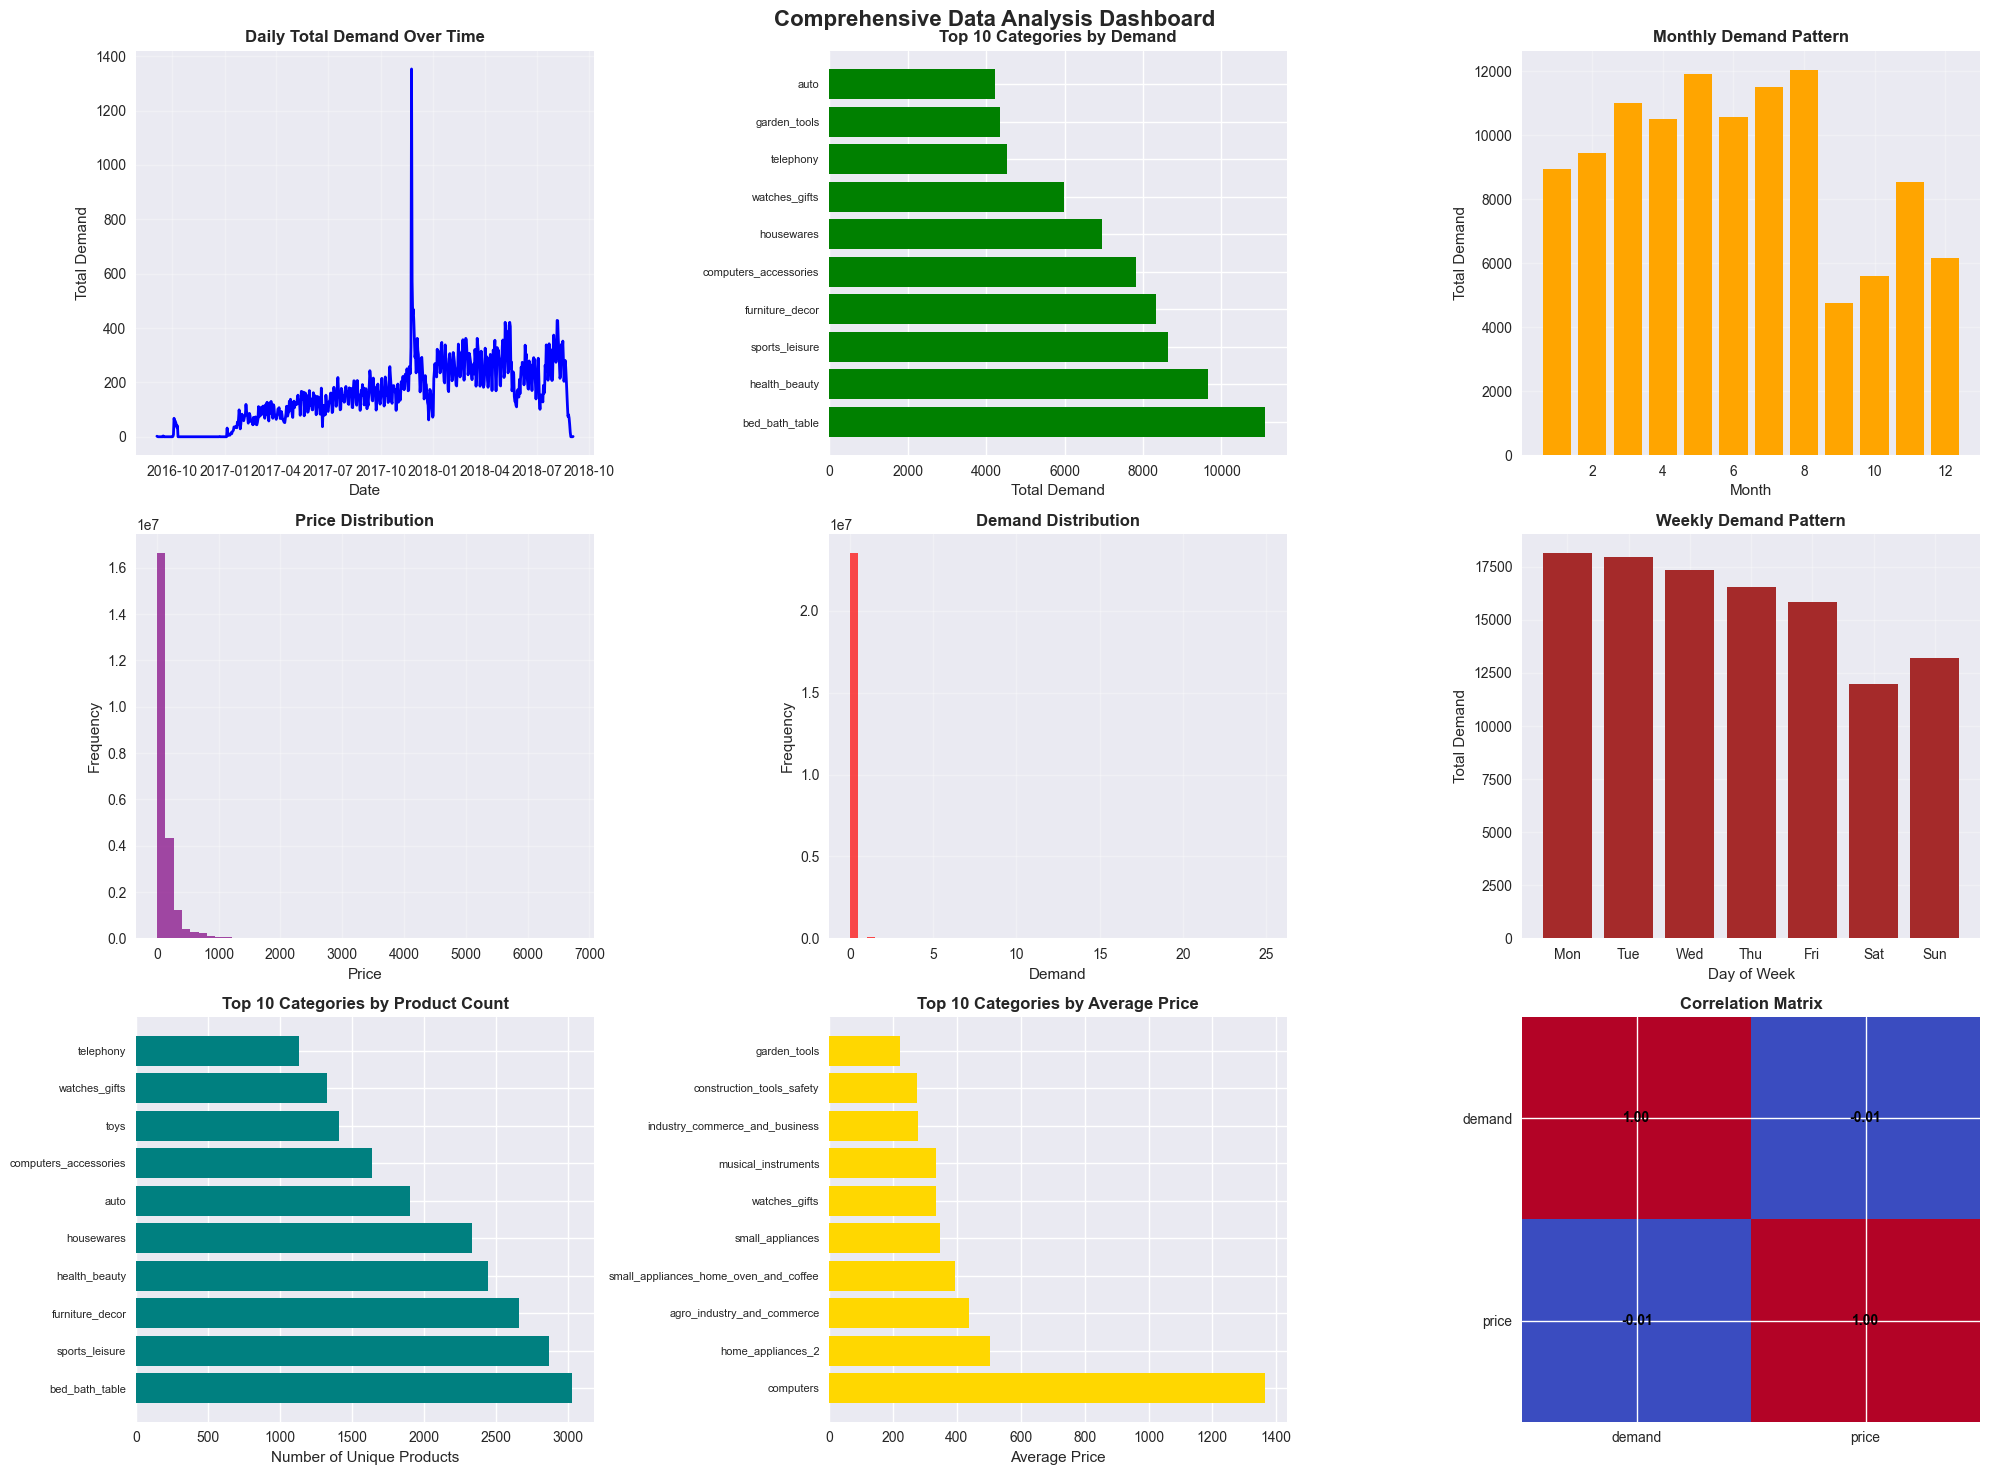

✓ Comprehensive visualization dashboard created successfully


In [14]:
# Create comprehensive visualizations
print("=== CREATING COMPREHENSIVE VISUALIZATIONS ===")

# Set up the plotting area
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Comprehensive Data Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Daily demand over time
ax1 = axes[0, 0]
daily_demand = demand_aggregation.groupby('order_date')['demand'].sum()
ax1.plot(daily_demand.index, daily_demand.values, linewidth=2, color='blue')
ax1.set_title('Daily Total Demand Over Time', fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Demand')
ax1.grid(True, alpha=0.3)

# 2. Top 10 product categories by demand
ax2 = axes[0, 1]
category_demand = demand_aggregation.groupby('categ')['demand'].sum().sort_values(ascending=False).head(10)
ax2.barh(range(len(category_demand)), category_demand.values, color='green')
ax2.set_yticks(range(len(category_demand)))
ax2.set_yticklabels(category_demand.index, fontsize=8)
ax2.set_title('Top 10 Categories by Demand', fontweight='bold')
ax2.set_xlabel('Total Demand')

# 3. Monthly demand pattern
ax3 = axes[0, 2]
demand_aggregation['month'] = pd.to_datetime(demand_aggregation['order_date']).dt.month
monthly_demand = demand_aggregation.groupby('month')['demand'].sum()
ax3.bar(monthly_demand.index, monthly_demand.values, color='orange')
ax3.set_title('Monthly Demand Pattern', fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Total Demand')
ax3.grid(True, alpha=0.3)

# 4. Price distribution
ax4 = axes[1, 0]
ax4.hist(demand_aggregation['price'], bins=50, alpha=0.7, color='purple')
ax4.set_title('Price Distribution', fontweight='bold')
ax4.set_xlabel('Price')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

# 5. Demand distribution
ax5 = axes[1, 1]
ax5.hist(demand_aggregation['demand'], bins=50, alpha=0.7, color='red')
ax5.set_title('Demand Distribution', fontweight='bold')
ax5.set_xlabel('Demand')
ax5.set_ylabel('Frequency')
ax5.grid(True, alpha=0.3)

# 6. Weekly demand pattern
ax6 = axes[1, 2]
demand_aggregation['day_of_week'] = pd.to_datetime(demand_aggregation['order_date']).dt.dayofweek
weekly_demand = demand_aggregation.groupby('day_of_week')['demand'].sum()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax6.bar(range(7), weekly_demand.values, color='brown')
ax6.set_xticks(range(7))
ax6.set_xticklabels(day_names)
ax6.set_title('Weekly Demand Pattern', fontweight='bold')
ax6.set_xlabel('Day of Week')
ax6.set_ylabel('Total Demand')
ax6.grid(True, alpha=0.3)

# 7. Unique products per category
ax7 = axes[2, 0]
products_per_category = demand_aggregation.groupby('categ')['product_id'].nunique().sort_values(ascending=False).head(10)
ax7.barh(range(len(products_per_category)), products_per_category.values, color='teal')
ax7.set_yticks(range(len(products_per_category)))
ax7.set_yticklabels(products_per_category.index, fontsize=8)
ax7.set_title('Top 10 Categories by Product Count', fontweight='bold')
ax7.set_xlabel('Number of Unique Products')

# 8. Average price by category
ax8 = axes[2, 1]
avg_price_by_category = demand_aggregation.groupby('categ')['price'].mean().sort_values(ascending=False).head(10)
ax8.barh(range(len(avg_price_by_category)), avg_price_by_category.values, color='gold')
ax8.set_yticks(range(len(avg_price_by_category)))
ax8.set_yticklabels(avg_price_by_category.index, fontsize=8)
ax8.set_title('Top 10 Categories by Average Price', fontweight='bold')
ax8.set_xlabel('Average Price')

# 9. Correlation heatmap
ax9 = axes[2, 2]
numeric_cols = ['demand', 'price']
if len(numeric_cols) > 1:
    corr_matrix = demand_aggregation[numeric_cols].corr()
    im = ax9.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
    ax9.set_xticks(range(len(numeric_cols)))
    ax9.set_yticks(range(len(numeric_cols)))
    ax9.set_xticklabels(numeric_cols)
    ax9.set_yticklabels(numeric_cols)
    ax9.set_title('Correlation Matrix', fontweight='bold')
    
    # Add correlation values as text
    for i in range(len(numeric_cols)):
        for j in range(len(numeric_cols)):
            ax9.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                    ha='center', va='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Comprehensive visualization dashboard created successfully")


## Final Dataset Contains

The exported CSV has these columns:
- `order_date` - Date of the order
- `product_id` - Unique product identifier  
- `price` - Product price
- `categ` - Product category
- `demand` - Number of items ordered

## Ready for Forecasting

Your processed data is now ready for demand forecasting models using the clean `demand_data_pp.csv` file!
